Part 1: Reading the CSV file

In [1]:
import pandas as pd
import tensorflow as tf
import scipy

# load the dataset
data_path = 'data/data.csv'
dataset = pd.read_csv(data_path)

print(dataset.head())

2024-02-25 22:47:39.388077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


                images texture
0  _7UfL2egoN0_300.png    hard
1   _22eJvtP_lc_50.png    hard
2  _CT7KRej9AY_100.png    hard
3  _Itl2z9fUQA_150.png    hard
4  _UoRGJmsRqY_100.png    hard


Part 2: Normalize the images

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Data augmentation: rotation
    width_shift_range=0.2,  # Data augmentation: horizontal shift
    height_shift_range=0.2,  # Data augmentation: vertical shift
    shear_range=0.2,  # Data augmentation: shearing
    zoom_range=0.2,  # Data augmentation: zooming
    horizontal_flip=True,  # Data augmentation: horizontal flip
    fill_mode='nearest',
    validation_split=0.2  # Splitting data: 80% train, 20% validation
)

Part 3: Loading the data

In [3]:
train_generator = datagen.flow_from_dataframe(
    dataframe=dataset,
    directory='data/images',
    x_col='images',  # Column in dataframe containing the filenames
    y_col='texture',  # Column in dataframe containing the labels
    target_size=(150, 150),  # Resize target
    color_mode='rgb',
    class_mode='categorical',  # For multi-class classification
    batch_size=2,
    subset='training'  # Specify using the 'validation_split' from ImageDataGenerator
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=dataset,
    directory='data/images',
    x_col='images',
    y_col='texture',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    subset='validation'  # Specify using the 'validation_split' from ImageDataGenerator
)

Found 72 validated image filenames belonging to 3 classes.
Found 18 validated image filenames belonging to 3 classes.


Visualizing data

Dataset size: (90, 2)
Class distribution:
 texture
hard     30
clay     30
grass    30
Name: count, dtype: int64


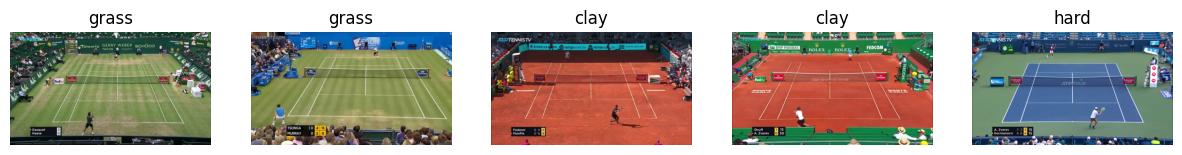

In [4]:
import matplotlib.pyplot as plt

# Assuming `dataset` is your DataFrame loaded from the CSV
print("Dataset size:", dataset.shape)
print("Class distribution:\n", dataset['texture'].value_counts())

# Visualize a few images from each class
def visualize_sample_images(df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for ax, (_, row) in zip(axes, df.sample(num_images, replace=False).iterrows()):
        img = plt.imread(f"data/images/{row['images']}")
        ax.imshow(img)
        ax.set_title(row['texture'])
        ax.axis('off')
    plt.show()

visualize_sample_images(dataset)

Build and Train the Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust according to the number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())
print(dataset.head())
print(f"Train generator samples: {train_generator.n}")
print(f"Validation generator samples: {validation_generator.n}")

steps_per_epoch = max(1, train_generator.n // train_generator.batch_size)
validation_steps = max(1, validation_generator.n // validation_generator.batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

Evaluation

In [6]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

36/36 [==============================] - 3s 88ms/step - loss: 7.1041e-05 - accuracy: 1.0000
Training Loss: 7.104102405719459e-05
Training Accuracy: 1.0
9/9 [==============================] - 1s 71ms/step - loss: 0.0485 - accuracy: 0.9444
Validation Loss: 0.048511914908885956
Validation Accuracy: 0.9444444179534912


Plotting the accuracy

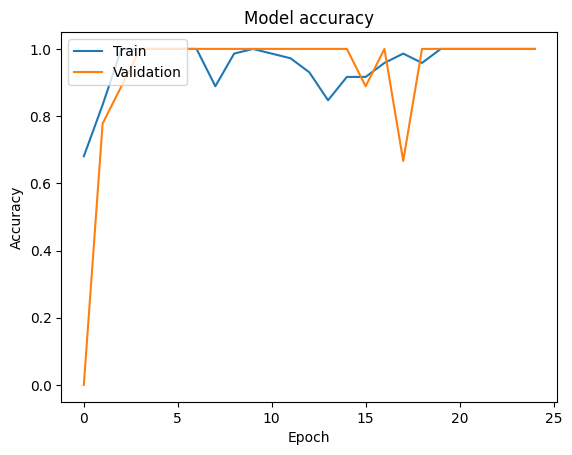

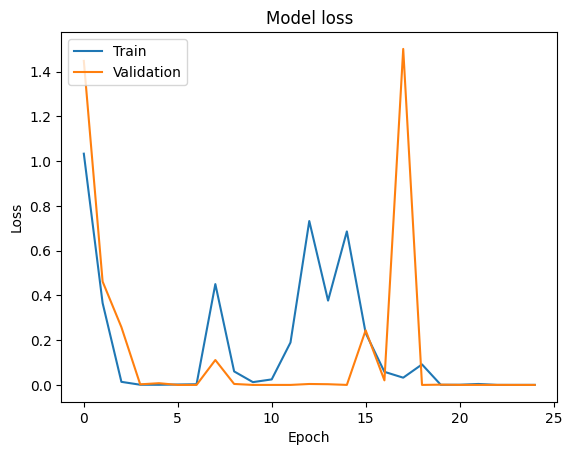

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Saving Model

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/nz/cxg8z6v123b1yq8_qbttt1yw0000gn/T/tmp52j_q8dm/assets


INFO:tensorflow:Assets written to: /var/folders/nz/cxg8z6v123b1yq8_qbttt1yw0000gn/T/tmp52j_q8dm/assets
2024-02-26 10:16:08.598259: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-26 10:16:08.598294: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-26 10:16:08.600884: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/nz/cxg8z6v123b1yq8_qbttt1yw0000gn/T/tmp52j_q8dm
2024-02-26 10:16:08.603668: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-26 10:16:08.603693: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/nz/cxg8z6v123b1yq8_qbttt1yw0000gn/T/tmp52j_q8dm
2024-02-26 10:16:08.610247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-26 10:16:08.612065: I tensorflow/cc/saved_model/load

Predictions

In [19]:
# Initialize the test data generator with only rescaling, no data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test_generator
test_generator = test_datagen.flow_from_directory(
    directory='data/test',  # Specify the path to your test data
    target_size=(150, 150),  # Target size should match the input size of your model
    color_mode='rgb',  # Assuming your model expects color images
    batch_size=2,  # Can be adjusted depending on your needs
    class_mode='categorical',  # Assuming you're doing categorical classification
    shuffle=False  # Typically, you don't shuffle the test set
)

print(f"test generator samples: {test_generator.n}")

predictions = model.evaluate(test_generator)

Found 27 images belonging to 3 classes.
test generator samples: 27
14/14 [==============================] - 1s 62ms/step - loss: 0.0022 - accuracy: 1.0000


In [22]:
"""
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img_path = 'data/test_images/1.png'
img = image.load_img(img_path, target_size=(150, 150))  # Resize the image to 150x150
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add a fourth dimension because Keras expects a list of images
img_array /= 255.0  # Rescale by 1/255 if your model expects data to be normalized

# Predict the class
predictions = model.predict(img_array)

# Assuming your model outputs logits, you may want to apply a softmax to convert these to probabilities
predicted_class_indices = np.argmax(predictions, axis=1)

class_names = ['clay', 'grass', 'hard']  # Example: class names

# Translate indices to names
predicted_class_names = [class_names[i] for i in predicted_class_indices]
print(f"Predicted court type: {predicted_class_names[0]}")
"""

1/1 [==============================] - 0s 101ms/step
Predicted court type: hard
